In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hed,hed2rgb
from skimage.exposure import rescale_intensity
from skimage.io  import imread,imsave
#from tifffile import imread, imwrite
import os
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from datetime import datetime
m2 = StarDist2D.from_pretrained('2D_versatile_he')
time_now=datetime.now().strftime("%m-%d-%Y-%H-%M")

2024-05-07 20:02:04.419143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found model '2D_versatile_he' for 'StarDist2D'.


2024-05-07 20:02:06.101263: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-07 20:02:06.101755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-07 20:02:06.123754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-05-07 20:02:06.123775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-07 20:02:06.140701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-07 20:02:06.140736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-0

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [9]:
#Read Images from given path
imgs_ihc=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/IHC_same_section_TIFF_Cropped_and_Correct/*"))
imgs_he=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/H&E_TIFF_Cropped/*"))
#Start Iteration
j=0
time_now=datetime.now().strftime("%m-%d-%Y-%H-%M")
#Set save paths
p="/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/gt_same_section_validation/"+time_now+"/"
p1=p+"all_blue_nuclei/"
p2=p+"cd3_postive_nuclei/"
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)

for p_he,p_ihc in zip(imgs_he,imgs_ihc):
    
    #H&E Image processing
    
    #Read image
    img_he=imread(p_he)
    
    #Label all blue nuclei
    labels, a = m2.predict_instances(normalize(img_he))
    
    #Save as image for proof and to re-map labels
    plt.imsave(p1+f"{j:03d}"+".png",labels,cmap="gray")
    
    #Read again
    b_n=cv2.imread(p1+f"{j:03d}"+".png",0)
    
    #Set binary threshold for all nuclei
    r,t1=cv2.threshold(b_n,0,255,cv2.THRESH_BINARY)
    
    #IHC Image processing
    
    img_ihc=imread(p_ihc)
    
    #Stain Deconvolution
    ihc_hed = rgb2hed(img_ihc)
    
    #Extracting DAB regions
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
    
    #Converting to single Channel Image
    d=cv2.cvtColor(np.array(ihc_d*255,np.uint8),cv2.COLOR_RGB2GRAY)
    
    #(1-(d-np.min(d))/(np.max(d)-np.min(d)))*255
    
    #Using a threshold to extract medium-dark CD3 postive regions 
    
    r,t2=cv2.threshold((1-(d-np.min(d))/(np.max(d)-np.min(d)))*255,50,255,cv2.THRESH_BINARY)
    
    #Dilate regions to get a soft mask
    kernel = np.ones((7, 7), np.uint8)
    img_dilation = cv2.dilate(t2, kernel, iterations=1)
    
    
    #r,t=cv2.threshold(d*255,50,255,cv2.THRESH_BINARY)
    #imsave(p1+"/"+f"{j:03d}"+".tiff",d*255)
    
    #Resize IHC image with respect to H&E image
    img_color=cv2.resize(img_dilation,(img_he.shape[1],img_he.shape[0]))
    
    #Converting image from float to uint8
    img_color=np.asarray(img_color,np.uint8)
    #img_color=cv2.cvtColor(img_color,cv2.COLOR_GRAY2RGB)
    
    
    #bn_only=cv2.bitwise_and(cv2.cvtColor(t1,cv2.COLOR_GRAY2RGB),img_he)
    cd3p=cv2.bitwise_and(img_color,b_n)

    #cd3p=cv2.bitwise_and(img_color,bn_only)
    
    plt.imsave(p2+f"{j:03d}"+".png",cd3p,cmap="gray")
    
    j=j+1

2024-05-07 20:05:23.671436: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-07 20:05:23.690676: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700110000 Hz
2024-05-07 20:05:24.026775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-05-07 20:05:25.323879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-07 20:05:28.676423: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 849305600 exceeds 10% of free system memory.
2024-05-07 20:05:40.475523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 328485888 exceeds 10% of free system memory.
2024-05-07 20:05:40.660834: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 328485888 exceeds 10% of free system memory.
2024-05-07 20:05:44

KeyboardInterrupt: 

In [8]:
imgs_ihc

[]

In [13]:
#Read Images from given path
imgs_ihc=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/IHC_same_section_TIFF_Cropped_and_Correct/*"))
imgs_he=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/H&E_TIFF_Cropped/*"))
#Start Iteration
j=0

#Set save paths
#p="/home/saab/Desktop/gt_same_section_validation/"+time_now+"/"
p="/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/Validation Dataset/gt_same_section_validation/"+time_now+"/"
p1=p+"all_blue_nuclei/"
p2=p+"cd3_postive_nuclei/"
p3=p+"cd3_negative_nuclei/"
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
for p_he,p_ihc in zip(imgs_he,imgs_ihc):
    
    #H&E Image processing
    
    #Read image
    img_he=imread(p_he)
    
    #Label all blue nuclei
    labels, a = m2.predict_instances(normalize(img_he))
    np.save(p1+f"{j:03d}"+".npy",labels)
    
    #IHC Image processing
    
    img_ihc=imread(p_ihc)
    
    #Stain Deconvolution
    ihc_hed = rgb2hed(img_ihc)
    
    #Extracting DAB regions
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
    
    #Converting to single Channel Image
    d=cv2.cvtColor(np.array(ihc_d*255,np.uint8),cv2.COLOR_RGB2GRAY)
    
    #(1-(d-np.min(d))/(np.max(d)-np.min(d)))*255
    
    #Using a threshold to extract medium-dark CD3 postive regions 
    #50 -255 OLD COMBINATION
    r,t2=cv2.threshold((1-(d-np.min(d))/(np.max(d)-np.min(d)))*255,70,200,cv2.THRESH_BINARY)
    
    #Dilate regions to get a soft mask
    kernel = np.ones((7, 7), np.uint8)
    t2=cv2.resize(t2,(img_he.shape[1],img_he.shape[0]))
   
    img_dilation1 = cv2.dilate(t2, kernel, iterations=1)
    img_dilation2 = 255-img_dilation1
    
    #r,t=cv2.threshold(d*255,50,255,cv2.THRESH_BINARY)
    #imsave(p1+"/"+f"{j:03d}"+".tiff",d*255)
    
    
    

    cd3p=labels*np.logical_and(img_dilation1,labels)
    cd3n=labels-cd3p
    #cd3p=cv2.bitwise_and(img_color,bn_only)
    
    np.save(p2+f"{j:03d}"+".npy",cd3p)
    np.save(p3+f"{j:03d}"+".npy",cd3n)
    print(j)
    j=j+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


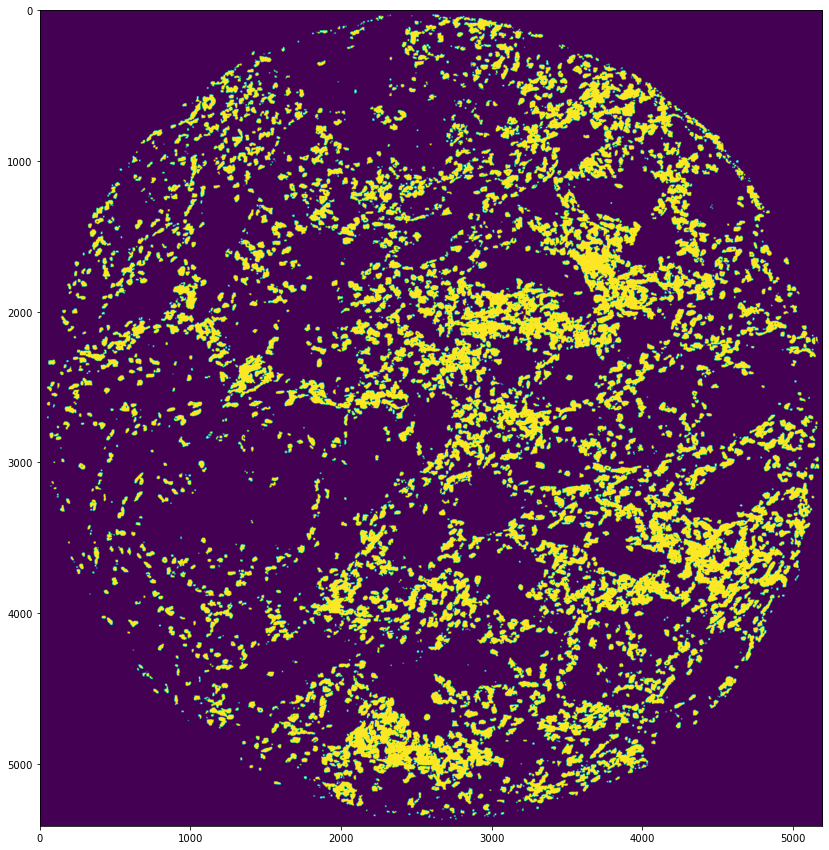

In [38]:
plt.figure(figsize=(15,15))
plt.imshow((img_dilation1))

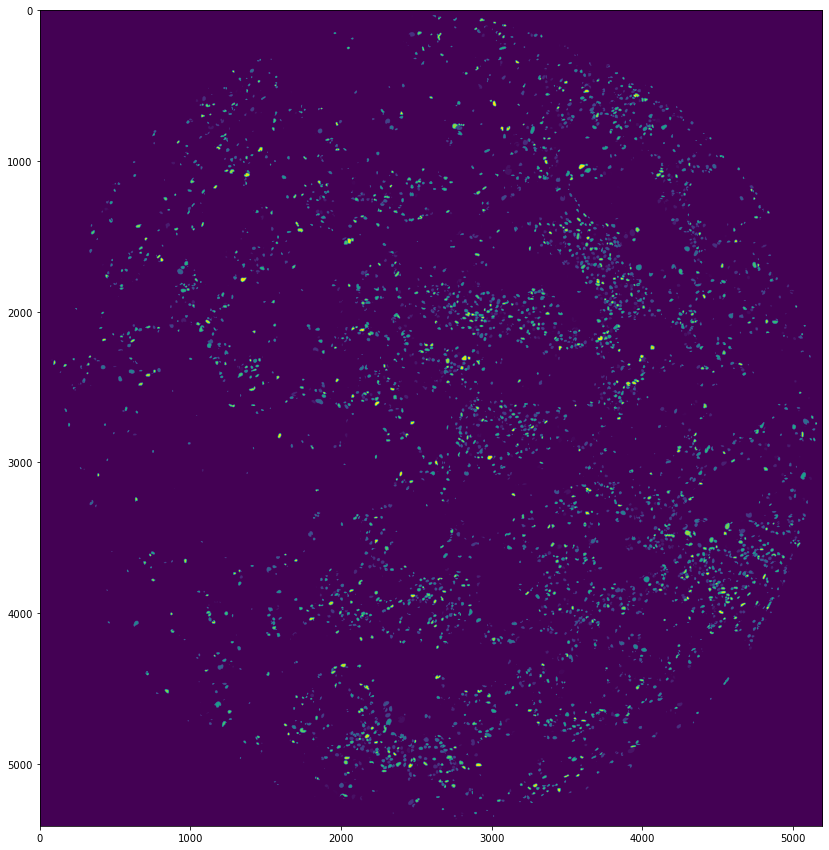

In [40]:
plt.figure(figsize=(15,15))
plt.imshow((cd3p))

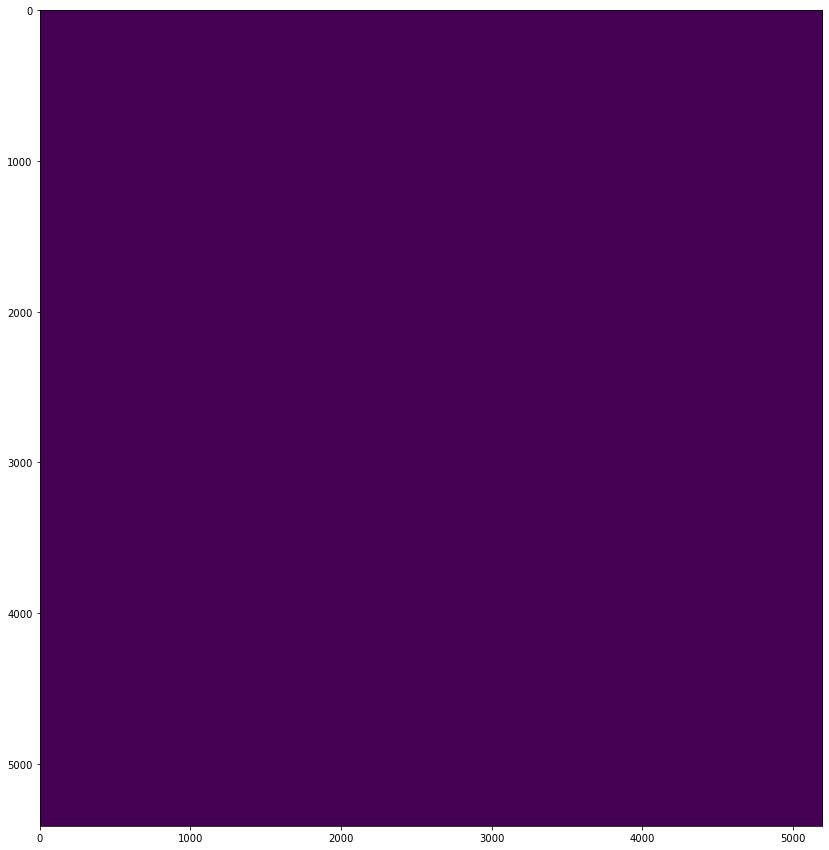

In [42]:
plt.figure(figsize=(15,15))
plt.imshow((labels-cd3n-cd3p))

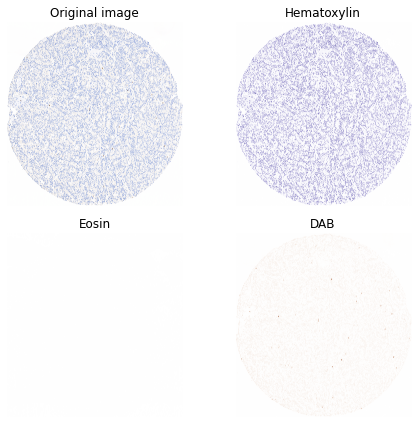

In [29]:
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [14]:
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

In [15]:
np.max(t)

255

In [16]:
imgs=sorted(glob("//home/saab/Desktop/*H&E*.tif"))
imgs

['//home/saab/Desktop/H&E_TIFF_s01.tif',
 '//home/saab/Desktop/H&E_TIFF_s03.tif']

In [17]:
m2 = StarDist2D.from_pretrained('2D_versatile_he')
def fn2(ims,pth):
    x=y
    lst=[]
    for img in ims:
        i = imread(img)
        #i=cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
        #pf=pth_main+"/"+f"{x:03d}"
        #print(pf+"/"+pth+".png")
        #os.makedirs(pf,exist_ok=True)
        labels, a = m2.predict_instances(normalize(i))
        #lst.append(len(np.unique(labels)))labr

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [18]:
for img in imgs:
        i = imread(img)
        
        labels, a = m2.predict_instances(normalize(i))
        

2022-10-13 18:50:03.381160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-13 18:50:03.400563: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699840000 Hz
2022-10-13 18:50:03.609964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-13 18:50:04.722647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


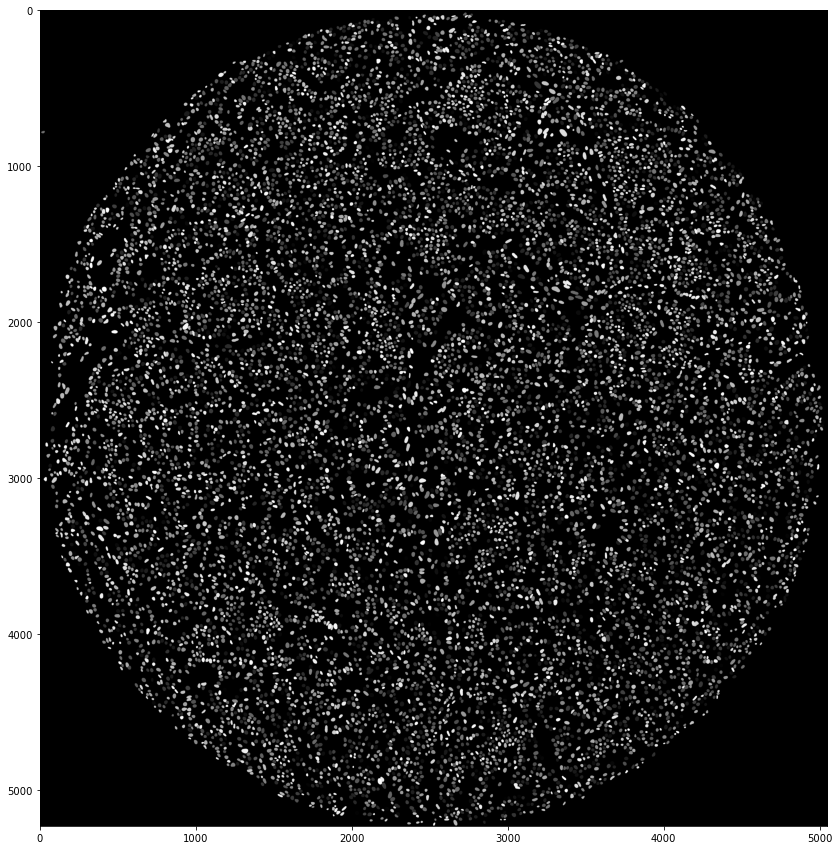

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(labels,cmap="gray")

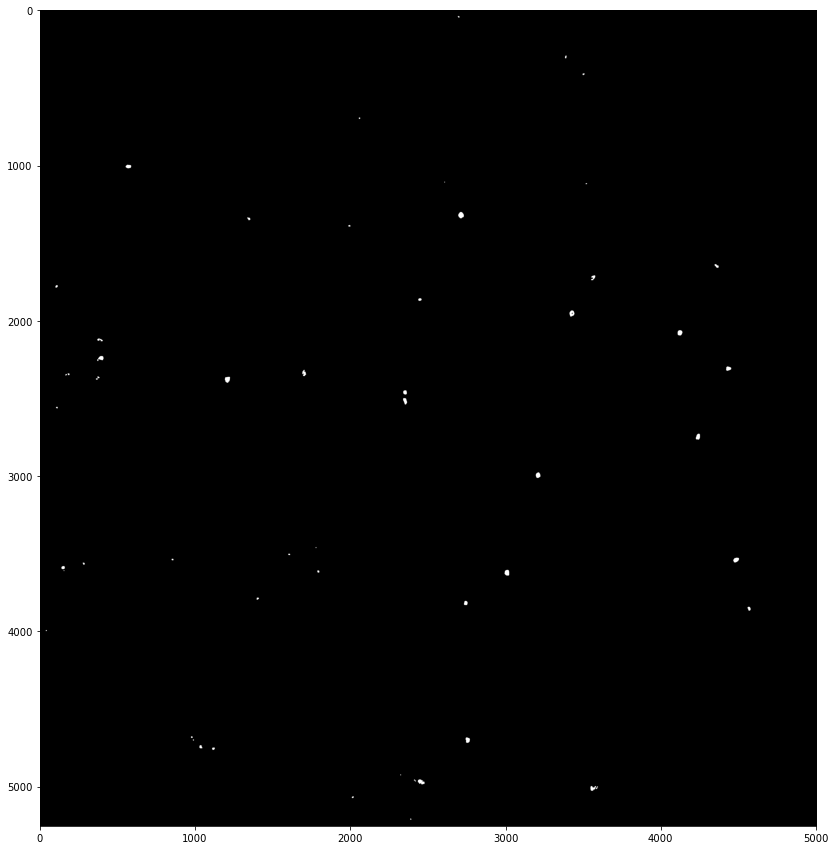

In [77]:
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(t2, kernel, iterations=1)
plt.figure(figsize=(15,15))
plt.imshow(img_dilation,cmap="gray")

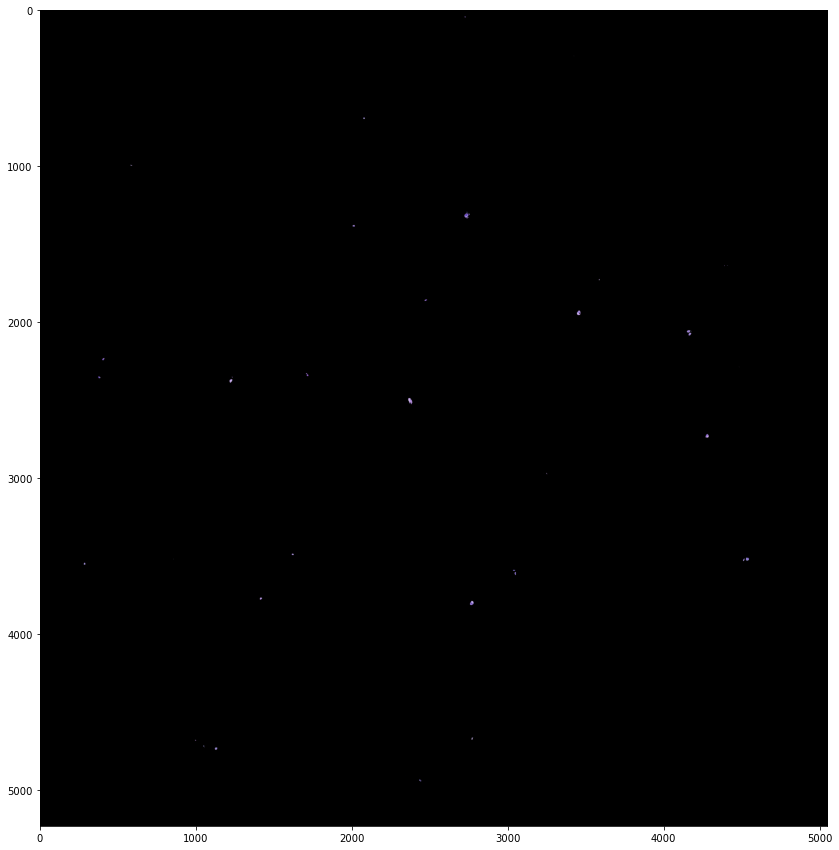

In [78]:
img_color=cv2.resize(img_dilation,(i.shape[1],i.shape[0]))
img_color=np.asarray(img_color,np.uint8)
img_color=cv2.cvtColor(img_color,cv2.COLOR_GRAY2RGB)
i=np.asarray(i,np.uint8)

plt.figure(figsize=(15,15))
plt.imshow(cv2.bitwise_and(img_color,bn_only))

In [79]:
plt.imsave("/home/saab/Desktop/dilation.png",cv2.bitwise_and(img_color,bn_only))

In [62]:
img_color.shape

(5047, 5227, 3)

In [68]:
bn_only=cv2.bitwise_and(cv2.cvtColor(t,cv2.COLOR_GRAY2RGB),i)

In [56]:
t2=cv2.resize(t2,(img_he.shape[1],img_he.shape[0]))
img_dilation = cv2.dilate(img_color, kernel, iterations=1)
np.unique(t2)

array([0.00000000e+00, 8.23558289e-04, 8.23558289e-04, ...,
       2.54999725e+02, 2.54999725e+02, 2.55000000e+02])

In [66]:
np.unique(labels*np.logical_and(img_color,labels))

array([   0,    1,    2, ..., 8171, 8173, 8175], dtype=int32)

In [28]:
from skimage.io import imsave
imsave("/home/saab/Desktop/test.png",labels)

1801797619.py (2): /home/saab/Desktop/test.png is a low contrast image
Lossy conversion from int32 to uint8. Range [0, 8177]. Convert image to uint8 prior to saving to suppress this warning.


In [26]:
np.dtype(labels)

TypeError: Cannot construct a dtype from an array

In [32]:
np.savez("/home/saab/Desktop/raw.npz",labels)

In [34]:
l2=np.load("/home/saab/Desktop/raw.npy")

In [47]:
np.unique(t2)

array([  0., 255.])

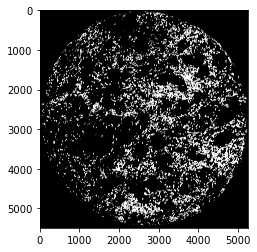

In [46]:
plt.imshow(t2,cmap="gray")

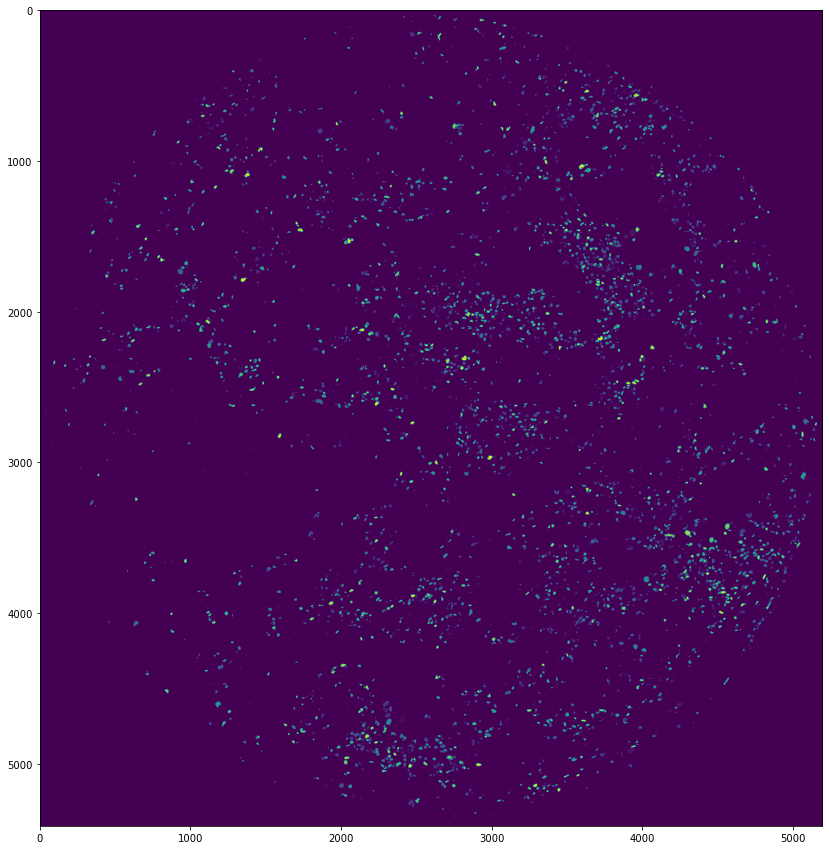

In [67]:
plt.figure(figsize=(15,15))
plt.imshow(labels*np.logical_and(img_color,labels))

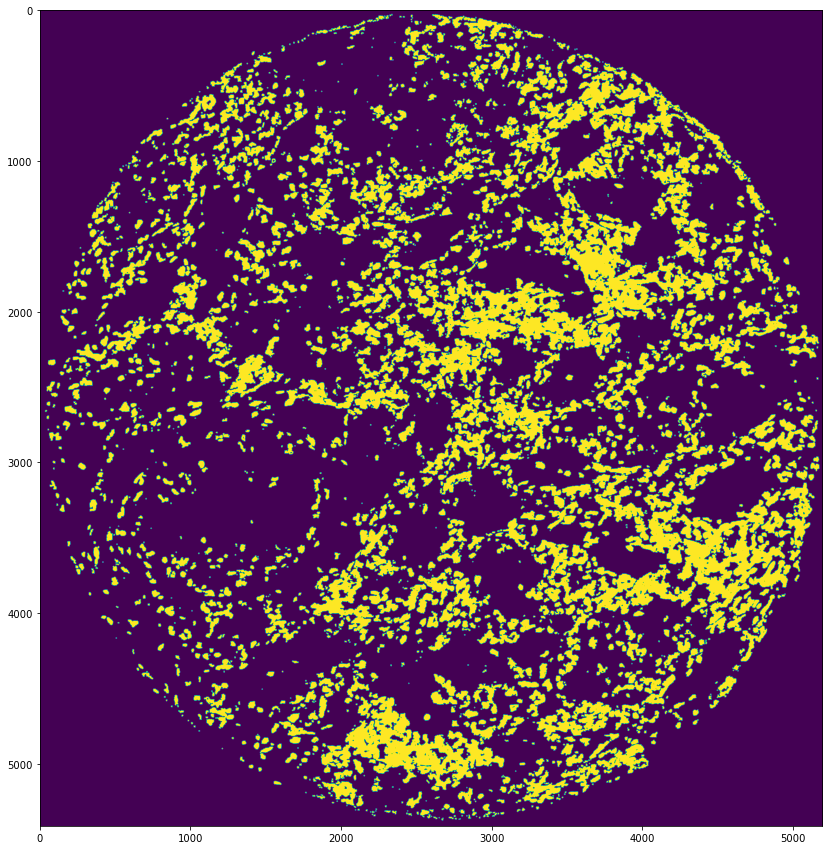

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(img_color)

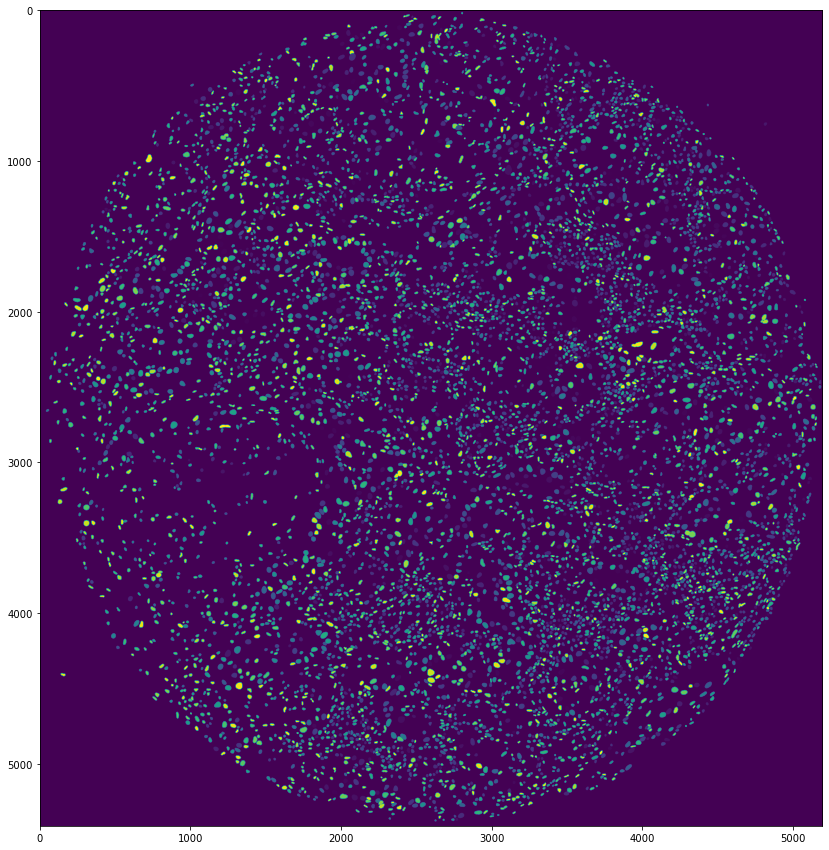

In [40]:
plt.figure(figsize=(15,15))
plt.imshow(labels)

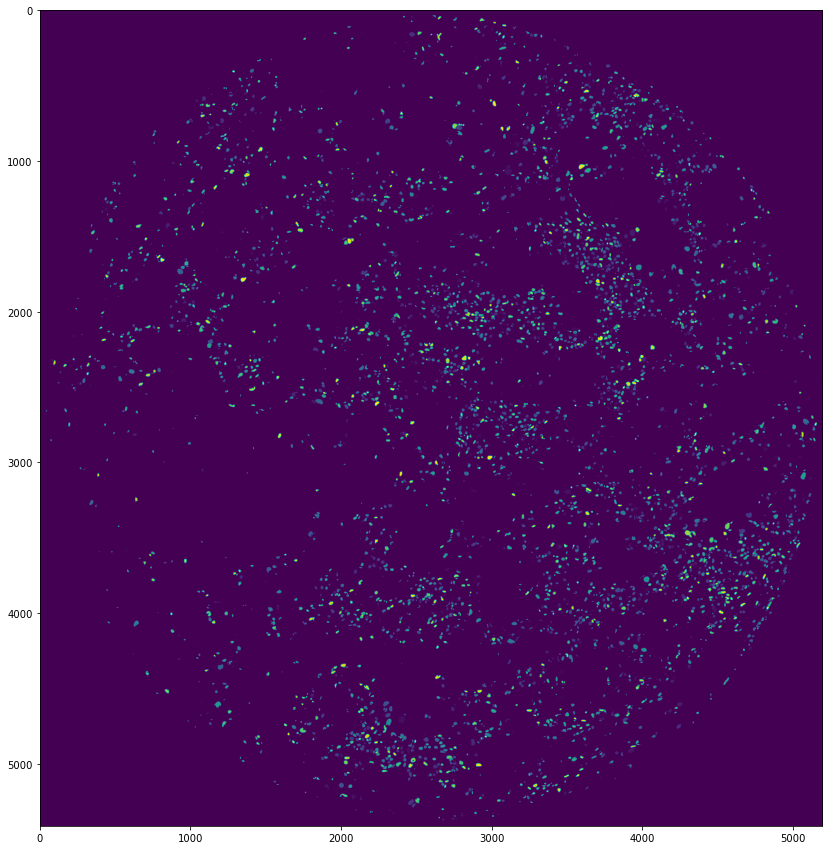

In [41]:
plt.figure(figsize=(15,15))
plt.imshow(cd3p)

In [63]:
np.logical_and([255,0,255], [1,2,8777])

array([ True, False,  True])

In [60]:
np.binary_repr(255)

'11111111'